In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as pp

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Business Description Data
## SP500 Data

In [5]:
my_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/SP500'
os.chdir(my_path)
fns = os.listdir(my_path)

ticker_sp50 = []
sector_sp50 = []
bds_sp50 = []
for fn in fns:
    fn_first = fn.split('.txt')[0]
    ticker = fn_first.split('_')[0]
    sector = fn_first.split('_')[1]
    f = open(fn, 'r')
    f_text = f.read()
    f.close()
    
    ticker_sp50.append(ticker)
    sector_sp50.append(sector)
    bds_sp50.append(f_text)

## Larger Dataset - excluding SP500

In [6]:
os.chdir('/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data')
f = open("bds_1.txt", "r")
f_lines = f.readlines()
f.close()

company_ids_all = f_lines[0::2]
company_descriptions_all = f_lines[1::2]
company_tickers = [x.split(':')[0] for x in company_ids_all]
removeSP = np.in1d(np.array(company_tickers), list(ticker_sp50))

bds_all = []
ticker_all = []
for i, d in enumerate(company_descriptions_all):
    if (len(d) > 3000) and not removeSP[i]:
        bds_all.append(d)
        ticker_all.append(company_ids_all[i])

# Get Returns Data

In [25]:
start_d = np.datetime64('2018-01-01')
end_d = np.datetime64('2020-01-01')
business_ds = pd.date_range(start_d, end_d, freq='B')

my_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/MarketData'
os.chdir(my_path)
price_data = pd.read_csv('Price.csv')

select_these = np.in1d(price_data.tic.values, list(ticker_sp50))
price_sp50 = price_data.loc[select_these, ['tic', 'datadate', 'prccd']]
price_sp50['datadate'] = pd.to_datetime(price_sp50['datadate'], format='%Y%m%d')
price_sp50 = pd.pivot_table(price_sp50,index='datadate',columns='tic',values='prccd')
price_sp50 = price_sp50.ffill(limit=5)
price_sp50 = price_sp50.reindex(business_ds)
price_sp50 = price_sp50.dropna(axis=0)

returns_sp50 = np.log(price_sp50) - np.log(price_sp50.shift(1))
returns_sp50 = returns_sp50.dropna(axis=0)

/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Explaining Returns with LDA
## Train LDA on Larger Dataset

In [9]:
n_features = 4000
tf_vectorizer = CountVectorizer(max_features=n_features, max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(bds_all)

n_components = 20
lda_20 = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda_20.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=20, random_state=0)

## Get Features for S&P 500

In [10]:
tf_sp50 = tf_vectorizer.transform(bds_sp50)

features_sp50 = lda_20.transform(tf_sp50)

features_sp50_df = pd.DataFrame(index=ticker_sp50, data=features_sp50)

## Loop Over Dates and Perform OLS Regression

In [27]:
all_dates = returns_sp50.index
max_f = 19
adj_r2_features = []

for dd in all_dates:
    reg_data = returns_sp50.loc[[dd]].transpose().join(features_sp50_df.loc[:, 0:max_f]).dropna(axis=0).values
    y = reg_data[:, 0]
    X = reg_data[:, 1:]

    std_scaler = StandardScaler()
    X = std_scaler.fit_transform(X)

    X = sm.add_constant(X, prepend=False)
    ols_model = sm.OLS(y, X)
    res = ols_model.fit()
    adj_r2_features.append(res.rsquared_adj)

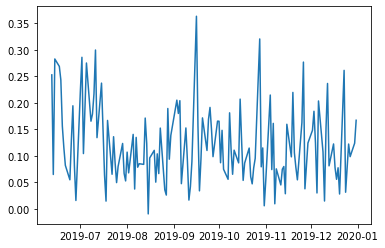

In [28]:
pp.plot(all_dates, adj_r2_features)

## Comparing Different K
First train models with different K

In [29]:

lda_k = []
for k in all_ks:
    
    lda_k.append(this_lda)

Next, calculate average regression adjusted $R^2$ for different K

In [ ]:
tf_sp50 = tf_vectorizer.transform(bds_sp50)
all_ks = [5, 10, 15, 20, 25, 30, 40, 50]
num_trials = 20
all_adj_r2 = []
for k in all_ks:
    print(f'Running for k = {k}')
    adj_r2_k = []
    for t in range(num_trials):
        this_lda = LatentDirichletAllocation(n_components=k, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.)
        this_lda.fit(tf)
    
        features_sp50 = this_lda.transform(tf_sp50)
        features_sp50_df = pd.DataFrame(index=ticker_sp50, data=features_sp50)
        adj_r2_dates = []
        for dd in all_dates:
            reg_data = returns_sp50.loc[[dd]].transpose().join(features_sp50_df.loc[:, 0:max_f]).dropna(axis=0).values
            y = reg_data[:, 0]
            X = reg_data[:, 1:]

            std_scaler = StandardScaler()
            X = std_scaler.fit_transform(X)

            X = sm.add_constant(X, prepend=False)
            ols_model = sm.OLS(y, X)
            res = ols_model.fit()
            adj_r2_dates.append(res.rsquared_adj)
        adj_r2_k.append(np.mean(adj_r2_dates))
    all_adj_r2.append(adj_r2_k)

Running for k = 5
Running for k = 10
Running for k = 15
Running for k = 20


In [35]:
all_adj_r2

[[0.030408537629349707, 0.03686655781212953],
 [0.08341156440450737, 0.06588298387103318]]